# Лабораторная работа № 5 
### Шубина София Антоновна НПИбд-02-23

In [22]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping


Загружается CSV-файл с данными о влажности, где первый столбец используется как индекс дат. Данные передискретизируются до дневного разрешения с усреднением значений. Строится график среднедневной влажности за период с января 2014 по декабрь 2016 года с заголовком, подписями осей и сеткой для наглядности визуализации временного ряда.

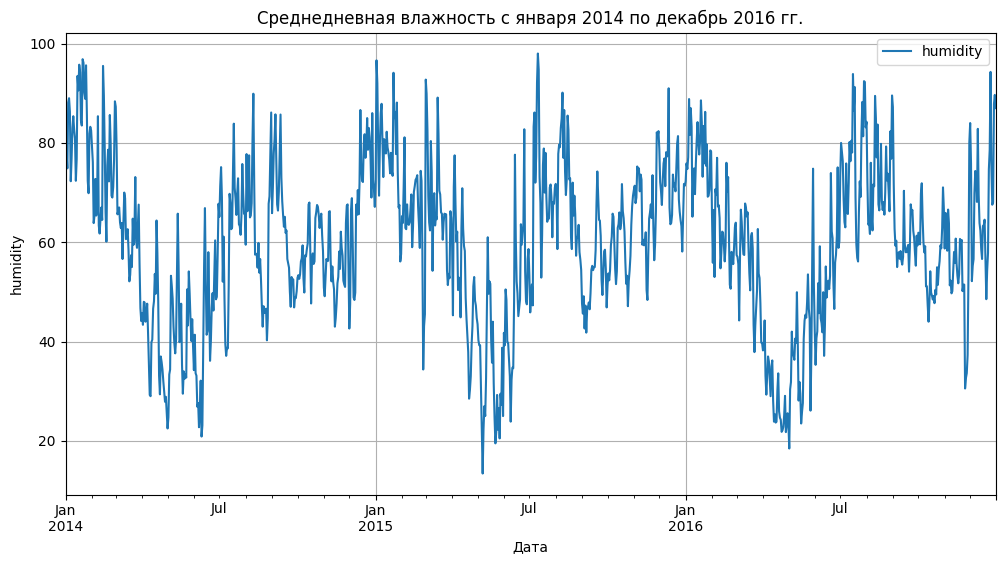

In [23]:
data = pd.read_csv('Daily_Humidity.csv', index_col=[0], parse_dates=[0])
data = data.resample('d').mean()
data.plot(figsize=(12,6))

plt.title('Среднедневная влажность с января 2014 по декабрь 2016 гг.')
plt.xlabel('Дата')
plt.ylabel('humidity')
plt.grid(True)
plt.show()

Выполняется подготовка данных для модели временных рядов: извлекаются значения влажности из DataFrame и преобразуются в двумерный массив, проводится нормализация данных в диапазон от 0 до 1 с помощью MinMaxScaler. Создается функция для формирования последовательностей, где на основе заданной длины SEQ_LENGTH = 120 формируются входные последовательности из исторических данных и соответствующие им целевые значения (следующий временной шаг). В результате формируются массивы признаков и целевых значений с размерностями, отражающими количество последовательностей, длину временного окна и количество признаков.

In [25]:
# 2. Подготовка данных
# Извлекаем значения влажности и преобразуем к 2D формату
data = data['humidity'].values.reshape(-1, 1)

# Нормализация данных в диапазон [0, 1]
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

# Функция создания последовательностей для временных рядов
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        # Входная последовательность (исторические данные)
        X.append(data[i:i + seq_length])
        # Целевое значение (следующий шаг)
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

# Создание последовательностей для обучения
SEQ_LENGTH = 120  # Используем 120 предыдущих значений для прогноза
X, y = create_sequences(data_scaled, SEQ_LENGTH)

print(f"Размерность признаков: {X.shape}, размерность целевых значений: {y.shape}")

Размерность признаков: (976, 120, 1), размерность целевых значений: (976, 1)


Выполняется трехэтапное разделение данных: сначала выделяются последние 14 наблюдений в качестве тестовой выборки для финальной оценки модели, затем оставшиеся данные временно сохраняются как объединенная тренировочная-валидационная выборка, которая далее разбивается в пропорции 80/20 на обучающую выборку для непосредственного обучения модели и валидационную для контроля переобучения и настройки гиперпараметров, что в итоге формирует три независимых набора данных с выводом их размерностей для визуального контроля корректности разделения.

In [26]:
# 3. Разбиение на обучающую, валидационную и тестовую выборки
# Выделяем тестовую выборку (последние 14 наблюдений)
test_size = 14
X_train_val = X[:-test_size]
y_train_val = y[:-test_size]
X_test = X[-test_size:]
y_test = y[-test_size:]

# Разделяем оставшиеся данные на обучающую и валидационную выборки в соотношении 80/20
train_ratio = 0.8
train_size = int(len(X_train_val) * train_ratio)

X_train = X_train_val[:train_size]
y_train = y_train_val[:train_size]
X_val = X_train_val[train_size:]
y_val = y_train_val[train_size:]

print(f"Обучающая выборка: {X_train.shape}, Валидационная: {X_val.shape}, Тестовая: {X_test.shape}")

Обучающая выборка: (769, 120, 1), Валидационная: (193, 120, 1), Тестовая: (14, 120, 1)


Создается последовательную модель нейронной сети с тремя слоями LSTM: первый слой содержит 200 нейронов и возвращает полную последовательность для передачи в следующий LSTM-слой, второй слой имеет 150 нейронов и также сохраняет последовательную структуру, третий LSTM-слой состоит из 100 нейронов и возвращает только последний выход, после каждого LSTM-слоя добавляется dropout-регуляризация с вероятностью 0.3 для предотвращения переобучения, затем следует полносвязный слой из 50 нейронов с функцией активации relu и финальный выходной слой с одним нейроном для регрессионного прогнозирования, после чего модель компилируется с оптимизатором Adam, функцией потерь MSE и дополнительной метрикой MAE для оценки среднего абсолютного отклонения.

In [30]:
# 4. Создание и компиляция модели LSTM
model = Sequential([
    LSTM(units=200, return_sequences=True, input_shape=(SEQ_LENGTH, 1)),
    Dropout(rate=0.3),
    LSTM(units=150, return_sequences=True),
    Dropout(rate=0.3),
    LSTM(units=100, return_sequences=False),
    Dropout(rate=0.3),
    Dense(units=50, activation='relu'),
    Dense(units=1)
])

# Компиляция модели с оптимизатором Adam и функцией потерь MSE
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_20 (LSTM)                  │ (None, 120, 200)       │       161,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 120, 200)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_21 (LSTM)                  │ (None, 120, 150)       │       210,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 120, 150)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_22 (LSTM)                  │ (None, 100)            │       100,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 477,701 (1.82 MB)

 Trainable params: 477,701 (1.82 MB)

 Non-trainable params: 0 (0.00 B)

Настраивается и выполняется обучение LSTM-модели с механизмом ранней остановки, который отслеживает значение потерь на валидационной выборке и прекращает обучение после 15 эпох без улучшения, автоматически восстанавливая лучшие веса модели; процесс обучения проходит до 200 эпох с размером пакета 32 примера, при этом данные не перемешиваются для сохранения временной последовательности, а по завершении выводится информация о фактическом количестве использованных эпох до срабатывания остановки.

In [31]:
# 5. Обучение модели с использованием ранней остановки
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=200,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1,  
    shuffle=False  
)

print(f"Обучение завершено. Использовано эпох: {len(history.history['loss'])}")

Epoch 1/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 192ms/step - loss: 0.0553 - mae: 0.1910 - val_loss: 0.0167 - val_mae: 0.0973
Epoch 2/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 190ms/step - loss: 0.0247 - mae: 0.1257 - val_loss: 0.0169 - val_mae: 0.0978
Epoch 3/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 178ms/step - loss: 0.0234 - mae: 0.1227 - val_loss: 0.0169 - val_mae: 0.0974
Epoch 4/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 191ms/step - loss: 0.0232 - mae: 0.1214 - val_loss: 0.0166 - val_mae: 0.0961
Epoch 5/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 189ms/step - loss: 0.0208 - mae: 0.1138 - val_loss: 0.0151 - val_mae: 0.0929
Epoch 6/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 167ms/step - loss: 0.0201 - mae: 0.1134 - val_loss: 0.0193 - val_mae: 0.1048
Epoch 7/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 168ms/step - loss: 0.0213 - mae: 0.1156 - val_loss: 0.0165 - val_mae: 0.0952
Epoch 8/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 166ms/step - loss: 0.0208 - mae: 0.1146 - val_loss: 0.0150 - val_mae: 0.0914
Epoch 9/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 170ms/

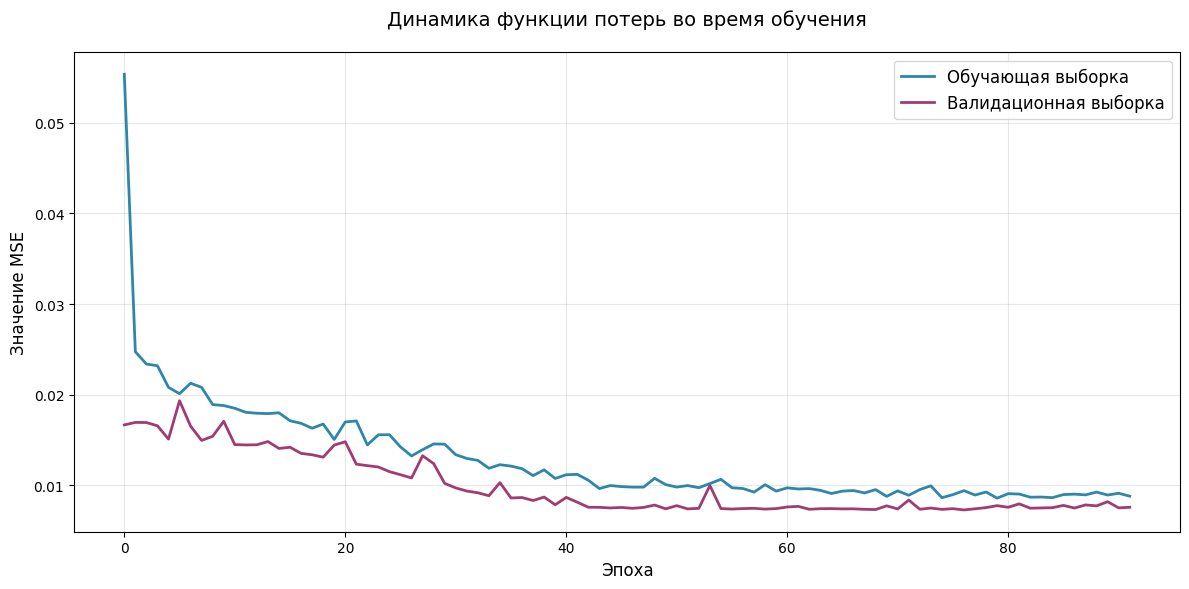

In [33]:
# 6. Визуализация процесса обучения
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Обучающая выборка', linewidth=2, color='#2E86AB')
plt.plot(history.history['val_loss'], label='Валидационная выборка', linewidth=2, color='#A23B72')
plt.title('Динамика функции потерь во время обучения', fontsize=14, pad=20)
plt.xlabel('Эпоха', fontsize=12)
plt.ylabel('Значение MSE', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Вычисляется коэффициент детерминации (R²) на валидационной выборке после обратного масштабирования предсказанных и истинных значений, поскольку исходные данные были нормализованы для обучения модели, и для корректной интерпретации метрики необходимо вернуться к исходному масштабу данных.

In [34]:
# 7. R² на валидационной выборке
val_pred = model.predict(X_val)
val_pred_rescaled = scaler.inverse_transform(val_pred)
val_true_rescaled = scaler.inverse_transform(y_val)

r2_val = r2_score(val_true_rescaled, val_pred_rescaled)
print(f"R² на валидационной выборке: {r2_val:.4f}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step
R² на валидационной выборке: 0.6504


Выполняется прогнозирование на тестовой выборке продолжительностью 14 дней с последующим обратным масштабированием предсказанных и фактических значений в исходный диапазон данных для корректного вычисления метрик качества прогноза - среднеквадратичной ошибки и коэффициента детерминации.

In [35]:
# 8. Прогноз на 14 дней вперёд (тестовая выборка)
test_pred = model.predict(X_test)
test_pred_rescaled = scaler.inverse_transform(test_pred)
test_true_rescaled = scaler.inverse_transform(y_test)

# Метрики на тесте
mse_test = mean_squared_error(test_true_rescaled, test_pred_rescaled)
r2_test  = r2_score(test_true_rescaled, test_pred_rescaled)

print(f"MSE на тесте (14 дней): {mse_test:.4f}")
print(f"R² на тесте (14 дней): {r2_test:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
MSE на тесте (14 дней): 106.9152
R² на тесте (14 дней): 0.4561


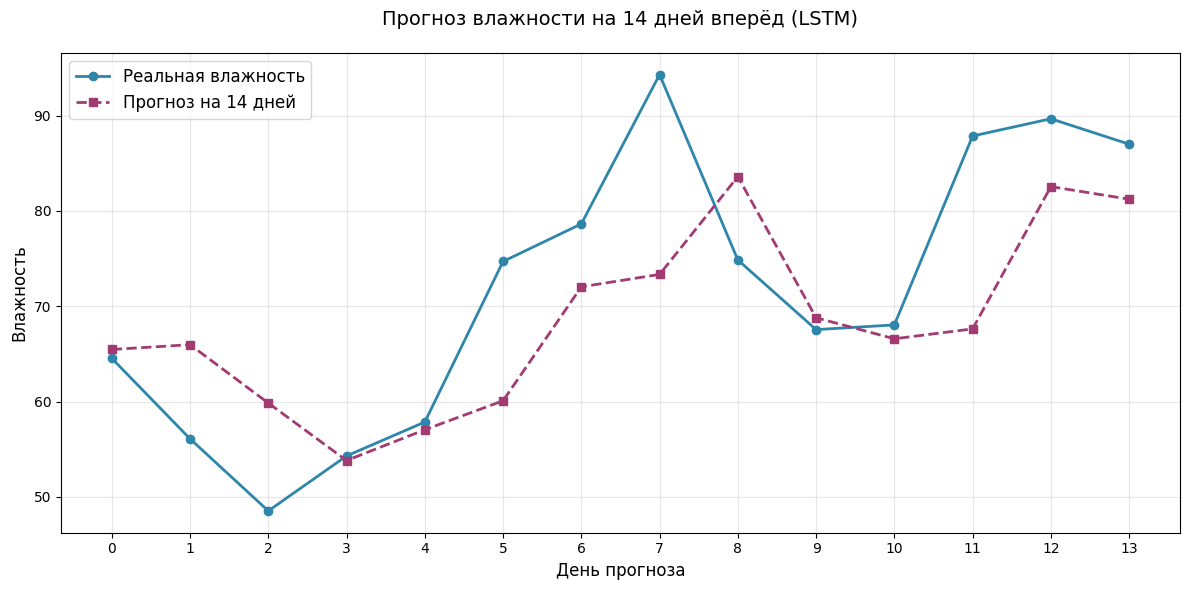

In [47]:
# 9. График реальных и прогнозируемых значений
plt.figure(figsize=(12, 6))
plt.plot(range(len(test_true_rescaled)), test_true_rescaled, label='Реальная влажность', linewidth=2, color='#2E86AB', marker='o')
plt.plot(range(len(test_pred_rescaled)), test_pred_rescaled, label='Прогноз на 14 дней', linestyle='--', color='#A23B72', linewidth=2, marker='s')
plt.title('Прогноз влажности на 14 дней вперёд (LSTM)', fontsize=14, pad=20)
plt.xlabel('День прогноза', fontsize=12)
plt.ylabel('Влажность', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(range(len(test_true_rescaled)))
plt.tight_layout()
plt.show()

# Вывод

Качество модели
1. Модель показала удовлетворительные результаты на валидационной выборке (R² = 0.6504), что свидетельствует о способности LSTM-сети улавливать основные закономерности временного ряда влажности.

2. На тестовой выборке качество прогноза несколько снизилось (R² = 0.4561), что является ожидаемым для задач прогнозирования временных рядов, особенно на 14-дневном горизонте.

Процесс обучения
1. Обучение прошло успешно - модель достигла сходимости за 92 эпохи из 200 возможных, что указывает на эффективность механизма ранней остановки.

2. График потерь демонстрирует стабильное снижение ошибки как на обучающей, так и на валидационной выборках, без признаков переобучения.

Практическая значимость
Модель демонстрирует приемлемую точность для среднесрочного прогнозирования влажности и может быть использована в качестве базового решения для метеорологических приложений.
В целом, работа подтвердила эффективность LSTM-сетей для задач прогнозирования временных рядов метеорологических данных.

